In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans


In [2]:
def plot_features(data, column_names, plot_name):
    plt.figure(figsize=(5,3))
    sns.violinplot(data=data, inner="quartile", palette="Set2")

    # Set labels
    plt.xticks(ticks=np.arange(len(column_names)), labels=column_names, rotation=30)
    plt.title(plot_name, fontsize=14)
    plt.ylabel("Value", fontsize=12)
    plt.xlabel("Features", fontsize=12)

    plt.tight_layout()
    plt.show()

In [3]:
### implementing the study of climate shift with kmeans
# 1. Stadardize.
# 2. PCA.
# 3. K-means.
# 4. Analysis of the start, end and duration of the seasons.

In [75]:
# Importing the data and creating the features
variables = [
'PRECTOTCORR',
# 'RH2M',
 'T2M',
 'T2M_MAX',
 'T2M_MIN',
 'WS2M']

features = []

doys = None
for variable in variables:
    #variable = variables[0]
    climate = pd.read_csv(fr'..\resources\{variable}\complete_dataset_{variable}.csv')

    if variable == 'PRECTOTCORR':
        new_feature = climate\
            .groupby(['YEAR','DOY'])\
            .mean()[climate.columns[-1]]\
            .rolling(window=15,min_periods=0).sum().to_list()
    else:
        new_feature = climate\
                .groupby(['YEAR','DOY'])\
                .mean()[climate.columns[-1]]\
                .to_list()
    if type(doys) == type(None) :
        doys = climate\
            .groupby(['YEAR','DOY'])\
            .mean().reset_index().DOY.to_numpy()

    features.append(new_feature)

features = np.array(features).T


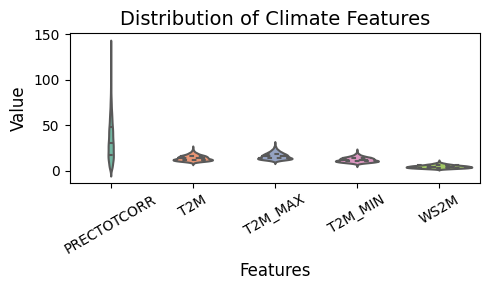

In [76]:
plot_features(features, variables, "Distribution of Climate Features")

In [77]:
normalizer = MinMaxScaler((0,1))
normalized_features = normalizer.fit_transform(features)

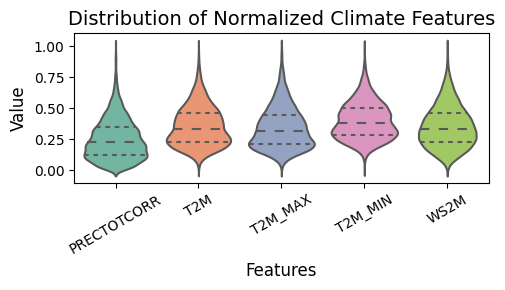

In [78]:
plot_features(normalized_features, variables, "Distribution of Normalized Climate Features")

In [79]:
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(normalized_features)

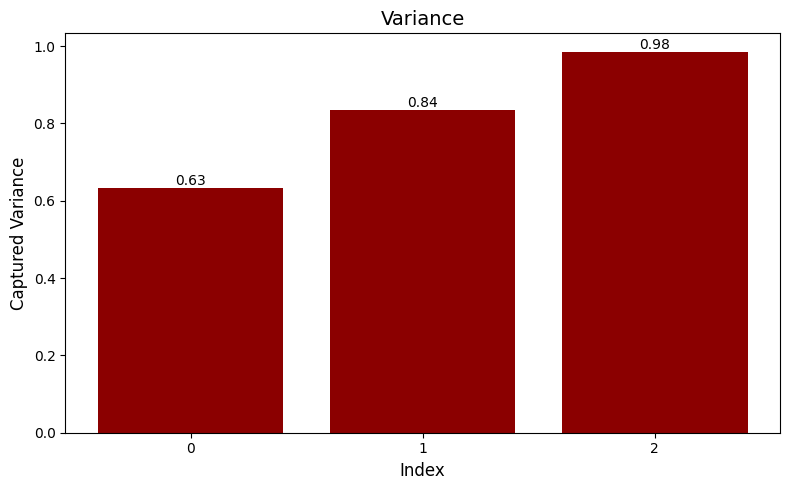

In [80]:
# variance captured by the number of components.

accumulated = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8,5))
plt.bar(range(len(accumulated)), accumulated, color="darkred")
for i, val in enumerate(accumulated):
    plt.text(i, val , str(round(val,2)), ha='center', va='bottom', fontsize=10)
# Labels
plt.title("Variance", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Captured Variance", fontsize=12)
plt.xticks(range(len(pca.explained_variance_ratio_)))

plt.tight_layout()
plt.show()

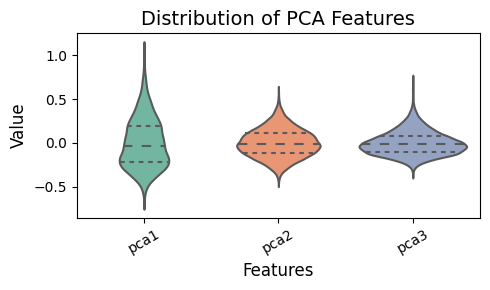

In [81]:
plot_features(reduced_features, ['pca1','pca2','pca3'], "Distribution of PCA Features")

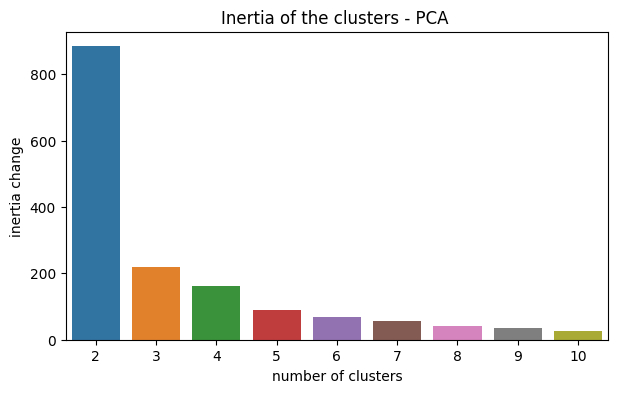

In [82]:
lst_inertias = []
for k in range(1,11):
    model = KMeans(n_clusters=k, n_init=60)
    model.fit(reduced_features)
    lst_inertias.append(model.inertia_)
inertia_variations = [abs(inert - lst_inertias[0]) for inert in lst_inertias]
inertia_variations_ = [abs(lst_inertias[i] - lst_inertias[i+1]) for i in range(len(lst_inertias)-1)] 
plt.figure(figsize=(7,4))



plt.title(f'Inertia of the clusters - PCA ')
plt.xlabel('number of clusters')
plt.ylabel('inertia change')
plt.xticks(list(range(1,11)))
sns.barplot(x=list(range(2,11)),y= inertia_variations_)

plt.show()

In [83]:
model = KMeans(n_clusters=3, n_init=60)
other_centers = model.fit_predict(normalized_features)


In [84]:
df_data_seasons_kmeans = pd.DataFrame(features, columns=variables)
df_data_seasons_kmeans['SEASON'] = other_centers
df_data_seasons_kmeans['DOY'] = doys

<Axes: xlabel='T2M', ylabel='T2M_MAX'>

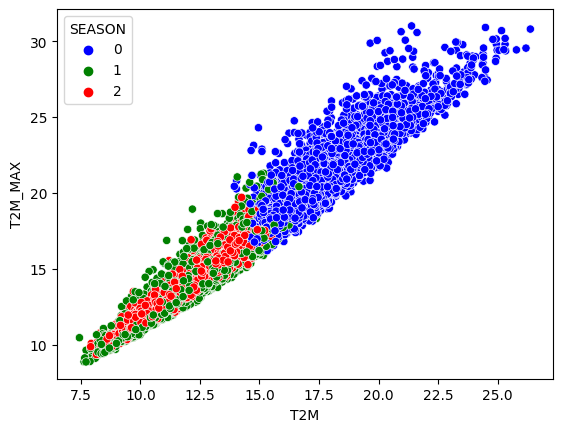

In [85]:
sns.scatterplot(data = df_data_seasons_kmeans, x='T2M', y='T2M_MAX',hue='SEASON',palette=['blue','green','red'])

<Axes: xlabel='DOY', ylabel='T2M_MAX'>

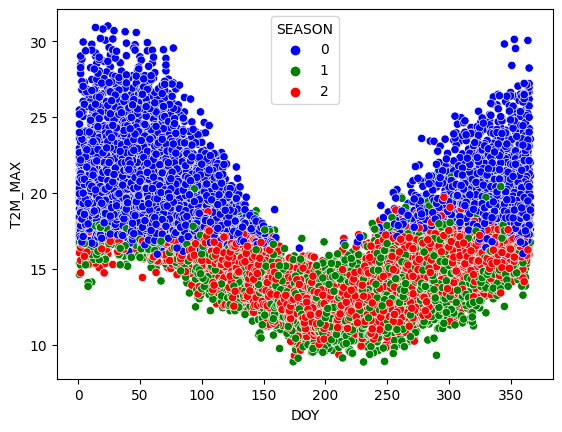

In [86]:
sns.scatterplot(data = df_data_seasons_kmeans, x='DOY', y='T2M_MAX',hue='SEASON',palette=['blue','green','red'])

In [37]:
variable= 'PRECTOTCORR'
climate = pd.read_csv(fr'..\resources\{variable}\complete_dataset_{variable}.csv')
new_feature = climate\
        .groupby(['YEAR','DOY'])\
        .mean()[climate.columns[-1]]\
        

<Axes: xlabel='YEAR,DOY'>

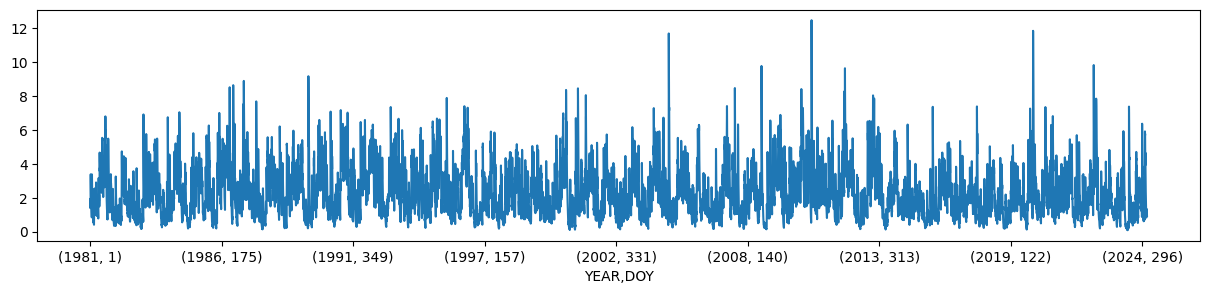

In [57]:
new_feature.ewm(span=15, adjust=False).mean().plot(figsize=(15,3))


In [61]:
new_feature.rolling(window=15,min_periods=0).sum()

YEAR  DOY
1981  1       1.5444
      2       3.2968
      3       3.6568
      4       9.3120
      5      10.1200
              ...   
2024  362    12.3992
      363    13.5864
      364    13.7972
      365    13.9668
      366    12.7708
Name: PRECTOTCORR, Length: 16071, dtype: float64